https://pywavelets.readthedocs.io/en/latest/ref/dwt-discrete-wavelet-transform.html
 
Descrete Wavelet transform adopted from paper [ available in the drive ]

2017_QuanyingZHANG_Amethodfor identifyingthethinlayerusingthewavelettransformofdensityloggingdata.

In the see that the cD  ie the detailed coefficients are one and the same for both db1 and haar wavelet discrete wavelet transform

In [ ]:
pip install pywavelets

In [ ]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import pywt

In [ ]:
filename = 'validation_data_nofacies.csv'
training_data = pd.read_csv(filename)
training_data.head()

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,A1 SH,STUART,2808.0,66.276,0.630,3.3,10.65,3.591,1,1.000
1,A1 SH,STUART,2808.5,77.252,0.585,6.5,11.95,3.341,1,0.978
2,A1 SH,STUART,2809.0,82.899,0.566,9.4,13.60,3.064,1,0.956
3,A1 SH,STUART,2809.5,80.671,0.593,9.5,13.25,2.977,1,0.933
4,A1 SH,STUART,2810.0,75.971,0.638,8.7,12.35,3.020,1,0.911


In [ ]:
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
       
facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS']

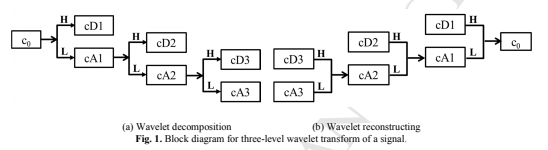

In [ ]:
#This function is defined for descrete wavelet transform and calculating the cA ie the approximate coefficient
def make_dwt_vars_cA(wells_df,logs,levels,wavelet):

    wave= pywt.Wavelet(wavelet)
    
    grouped = wells_df.groupby(['Well Name'])
    new_df = pd.DataFrame()
    for key in grouped.groups.keys():
    
        depth = grouped.get_group(key)['Depth']
        temp_df = pd.DataFrame()
        temp_df['Depth'] = depth
        for log in logs:
      
            temp_data = grouped.get_group(key)[log]
              
            for i in levels:
                
                    cA_cD = pywt.wavedec(temp_data,wave,level=i,mode='symmetric')
                    cA = cA_cD[0]
                    new_depth = np.linspace(min(depth),max(depth),len(cA))
                    fA = interp1d(new_depth,cA,kind='nearest')
                    temp_df[log + '_cA_level_' + str(i)] = fA(depth)
    
        new_df = new_df.append(temp_df)
        
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Depth'],axis=1)
    return new_df

In [ ]:
#This is a user defined function for discrte wavelet transform cD, cD is also called the detailed  coefficient
def make_dwt_vars_cD(wells_df,logs,levels,wavelet):

    wave= pywt.Wavelet(wavelet)
    
    grouped = wells_df.groupby(['Well Name'])
    new_df = pd.DataFrame()
    for key in grouped.groups.keys():
    
        depth = grouped.get_group(key)['Depth']
        temp_df = pd.DataFrame()
        temp_df['Depth'] = depth
        for log in logs:
      
            temp_data = grouped.get_group(key)[log]

            cA_4, cD_4, cD_3, cD_2, cD_1 = pywt.wavedec(temp_data,wave,level=4,mode='symmetric')
            dict_cD_levels = {1:cD_1, 2:cD_2, 3:cD_3, 4:cD_4}
                
            for i in levels:
                new_depth = np.linspace(min(depth),max(depth),len(dict_cD_levels[i]))
                fA = interp1d(new_depth,dict_cD_levels[i],kind='nearest')
                temp_df[log + '_cD_level_' + str(i)] = fA(depth)
    
        new_df = new_df.append(temp_df)
        
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Depth'],axis=1)
    return new_df

In [ ]:
#cD From wavelet db1
dwt_db4_cD_df = make_dwt_vars_cD(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                                    levels=[1, 2, 3, 4], wavelet='db4')

# cA From wavelet db1
dwt_db4_cA_df = make_dwt_vars_cA(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                       levels=[1, 2, 3, 4], wavelet='db4')

In [ ]:
list_df_var = [dwt_db4_cD_df, dwt_db4_cA_df]
combined_df = training_data
for var_df in list_df_var:
    temp_df = var_df
    combined_df = pd.concat([combined_df,temp_df],axis=1)
combined_df.replace(to_replace=np.nan, value='-1', inplace=True)
print (combined_df.shape)
training_data=combined_df

(800, 50)


In [ ]:
training_data.head()

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,GR_cD_level_1,GR_cD_level_2,GR_cD_level_3,GR_cD_level_4,ILD_log10_cD_level_1,ILD_log10_cD_level_2,ILD_log10_cD_level_3,ILD_log10_cD_level_4,DeltaPHI_cD_level_1,DeltaPHI_cD_level_2,DeltaPHI_cD_level_3,DeltaPHI_cD_level_4,PE_cD_level_1,PE_cD_level_2,PE_cD_level_3,PE_cD_level_4,PHIND_cD_level_1,PHIND_cD_level_2,PHIND_cD_level_3,PHIND_cD_level_4,GR_cA_level_1,GR_cA_level_2,GR_cA_level_3,GR_cA_level_4,ILD_log10_cA_level_1,ILD_log10_cA_level_2,ILD_log10_cA_level_3,ILD_log10_cA_level_4,DeltaPHI_cA_level_1,DeltaPHI_cA_level_2,DeltaPHI_cA_level_3,DeltaPHI_cA_level_4,PE_cA_level_1,PE_cA_level_2,PE_cA_level_3,PE_cA_level_4,PHIND_cA_level_1,PHIND_cA_level_2,PHIND_cA_level_3,PHIND_cA_level_4
0,A1 SH,STUART,2808.0,66.276,0.630,3.3,10.65,3.591,1,1.000,0.317086,-4.908028,2.432850,0.485644,-0.002140,0.021297,0.011742,-0.003506,0.289653,-1.637698,1.773079,0.020254,-0.028786,0.133672,-0.216281,0.004656,0.223213,-0.786759,0.589024,0.057702,108.875070,155.676966,215.809866,305.175985,0.892539,1.212950,1.712934,2.438761,12.464773,16.207367,20.222419,29.322773,4.230717,6.236185,9.110172,12.780711,17.946034,25.255832,34.775349,49.243161
1,A1 SH,STUART,2808.5,77.252,0.585,6.5,11.95,3.341,1,0.978,0.317086,-4.908028,2.432850,0.485644,-0.002140,0.021297,0.011742,-0.003506,0.289653,-1.637698,1.773079,0.020254,-0.028786,0.133672,-0.216281,0.004656,0.223213,-0.786759,0.589024,0.057702,108.875070,155.676966,215.809866,305.175985,0.892539,1.212950,1.712934,2.438761,12.464773,16.207367,20.222419,29.322773,4.230717,6.236185,9.110172,12.780711,17.946034,25.255832,34.775349,49.243161
2,A1 SH,STUART,2809.0,82.899,0.566,9.4,13.60,3.064,1,0.956,1.281410,-15.434743,2.432850,0.485644,-0.007728,0.069863,0.011742,-0.003506,0.745805,-4.933592,1.773079,0.020254,-0.061426,0.392317,-0.216281,0.004656,0.605206,-2.438726,0.589024,0.057702,116.584728,147.903228,215.809866,305.175985,0.805190,1.188535,1.712934,2.438761,12.708205,11.251806,20.222419,29.322773,4.384012,6.825388,9.110172,12.780711,18.698845,23.506592,34.775349,49.243161
3,A1 SH,STUART,2809.5,80.671,0.593,9.5,13.25,2.977,1,0.933,1.281410,-15.434743,2.432850,0.485644,-0.007728,0.069863,0.011742,-0.003506,0.745805,-4.933592,1.773079,0.020254,-0.061426,0.392317,-0.216281,0.004656,0.605206,-2.438726,0.589024,0.057702,116.584728,147.903228,215.809866,305.175985,0.805190,1.188535,1.712934,2.438761,12.708205,11.251806,20.222419,29.322773,4.384012,6.825388,9.110172,12.780711,18.698845,23.506592,34.775349,49.243161
4,A1 SH,STUART,2810.0,75.971,0.638,8.7,12.35,3.020,1,0.911,-2.448760,-15.434743,8.225127,0.485644,0.014389,0.069863,0.033239,-0.003506,-0.486751,-4.933592,5.863528,0.020254,0.066162,0.392317,-0.701616,0.004656,-0.646839,-2.438726,1.960815,0.057702,93.522200,147.903228,215.772642,305.175985,0.892547,1.188535,1.719741,2.438761,4.504288,11.251806,21.022345,29.322773,5.094049,6.825388,9.018405,12.780711,14.891867,23.506592,34.901832,49.243161


In [ ]:
training_data.to_csv('validation_data_nofacies_DB4.csv')

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR_cD_level_3, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10_cD_level_3, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI_cD_level_3, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND_cD_level_3, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE_cD_level_3, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR_cD_level_3")
    ax[0].set_xlim(logs.GR.GR_cD_level_3.min(),logs.GR_cD_level_3.max())
    ax[1].set_xlabel("ILD_log10_cD_level_3")
    ax[1].set_xlim(logs.ILD_log10_cD_level_3.min(),logs.ILD_log10_cD_level_3.max())
    ax[2].set_xlabel("DeltaPHI_cD_level_3")
    ax[2].set_xlim(logs.DeltaPHI_cD_level_3.min(),logs.DeltaPHI_cD_level_3.max())
    ax[3].set_xlabel("PHIND_cD_level_3")
    ax[3].set_xlim(logs.PHIND_cD_level_3.min(),logs.PHIND_cD_level_3.max())
    ax[4].set_xlabel("PE_cD_level_3")
    ax[4].set_xlim(logs.GR_cA_level_3.min(),logs.GR_cA_level_3.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Gamma ray and corresponding cD cofficients found via dB4 for Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)
    
make_facies_log_plot(
training_data[training_data['Well Name'] == 'ALEXANDER D'],facies_colors)

In [ ]:
filename = 'facies_PE_ET.csv'
training_data = pd.read_csv(filename)

In [ ]:
# cD from wavelet haar
dwt_haar_cD_df = make_dwt_vars_cD(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                       levels=[1, 2, 3, 4], wavelet='db4')
# cA from wavelet haar
dwt_haar_cA_df = make_dwt_vars_cA(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                       levels=[1, 2, 3, 4], wavelet='haar')

In [ ]:
list_df_var = [dwt_haar_cD_df, dwt_haar_cA_df]
combined_df = training_data
for var_df in list_df_var:
    temp_df = var_df
    combined_df = pd.concat([combined_df,temp_df],axis=1)
combined_df.replace(to_replace=np.nan, value='-1', inplace=True)
print (combined_df.shape)
training_data=combined_df

(4149, 51)


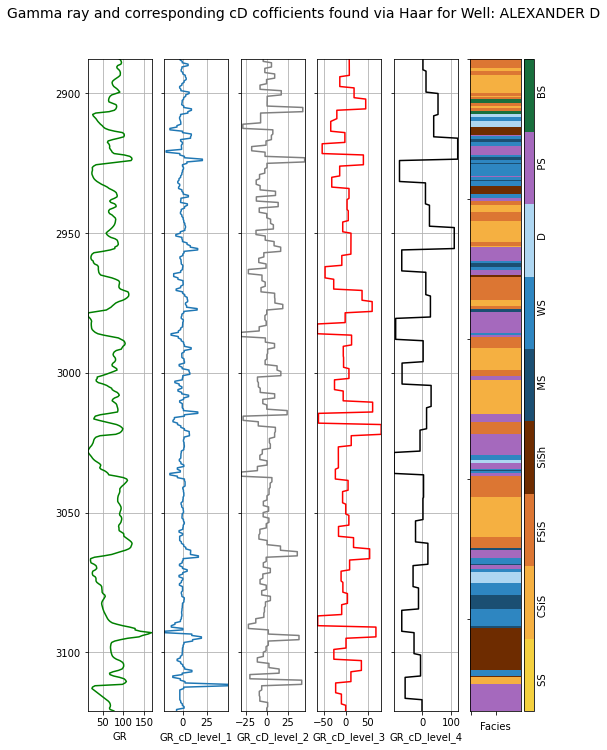

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.GR_cD_level_1, logs.Depth, '-')
    ax[2].plot(logs.GR_cD_level_2, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.GR_cD_level_3, logs.Depth, '-', color='r')
    ax[4].plot(logs.GR_cD_level_4, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("GR_cD_level_1")
    ax[1].set_xlim(logs.GR_cD_level_1.min(),logs.GR_cD_level_1.max())
    ax[2].set_xlabel("GR_cD_level_2")
    ax[2].set_xlim(logs.GR_cD_level_2.min(),logs.GR_cD_level_2.max())
    ax[3].set_xlabel("GR_cD_level_3")
    ax[3].set_xlim(logs.GR_cD_level_3.min(),logs.GR_cD_level_3.max())
    ax[4].set_xlabel("GR_cD_level_4")
    ax[4].set_xlim(logs.GR_cD_level_4.min(),logs.GR_cD_level_4.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Gamma ray and corresponding cD cofficients found via Haar for Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)
    
make_facies_log_plot(
training_data[training_data['Well Name'] == 'ALEXANDER D'],facies_colors)

We see that the cD the deatiled coefficients are one and the same for both db1 and haar dwt